# Import the libraries

In [ ]:
import os
import shutil
import numpy as np
import random
import matplotlib.pyplot as plt
import PIL
import glob
from PIL import Image
from google.colab import drive

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# Loading the data

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip gdrive/MyDrive/Incongruence_Data/data_image/nike.zip -d data
!unzip gdrive/MyDrive/Incongruence_Data/data_image/gucci.zip -d data
!unzip gdrive/MyDrive/Incongruence_Data/data_image/cristianoronaldo.zip -d data
!unzip gdrive/MyDrive/Incongruence_Data/data_image/edsheeran.zip -d data

# Preparing the data

In [ ]:
data_names = os.listdir('data/')
for name in data_names:
  class_names = os.listdir('data/' + name)
  for classes in class_names:
    if classes != '.ipynb_checkpoints':
      os.mkdir('data/' + name + '/' + 'data_' + classes)
      folders = os.listdir('data/' + name + '/' + classes)
      for folder in folders:
        for files in os.listdir('data/' + name + '/' + classes + '/' + folder):          
          shutil.move('data/' + name + '/' + classes + '/' + folder + '/' + files, 'data/' + name + '/' + 'data_' + classes)


a = 0
data_names = os.listdir('data/')
for name in data_names:
  for i in os.listdir('data/'+ name + '/Matches'):
    os.rmdir('data/' + name + '/Matches/' + i)

  for i in os.listdir('data/'+ name + '/Mismatches'):
    os.rmdir('data/' + name + '/Mismatches/' + i)

  os.rmdir('data/' + name + '/Matches')
  os.rmdir('data/' + name + '/Mismatches')

  os.rename('data/' + name + '/data_Matches', 'data/' + name + '/Matches')
  os.rename('data/' + name + '/data_Mismatches', 'data/' + name + '/Mismatches')

In [ ]:
data_names = os.listdir('data/')
for name in data_names:
  class_names = os.listdir('data/' + name)
  os.mkdir('data/' + name + '/' + 'train_data')
  for classes in class_names:
    if classes != '.ipynb_checkpoints':
      shutil.move('data/' + name + '/' + classes, 'data/' + name + '/' + 'train_data/')

In [ ]:
data_names = os.listdir('data/')
for name in data_names:
  test_num = round((len(os.listdir('data/' + name + '/train_data/Matches')) + len(os.listdir('data/' + name + '/train_data/Mismatches'))) * 0.05)
  class_names = os.listdir('data/' + name + '/' + 'train_data')
  os.mkdir('data/' + name + '/' + 'test_data')
  for classes in class_names:
    os.mkdir('data/' + name + '/' + 'test_data/' + classes)
    if classes != '.ipynb_checkpoints':
      data_list = os.listdir('data/' + name + '/' + 'train_data/' + classes)
      random.shuffle(data_list)
      for i in range(test_num):
          test_data = data_list.pop()
          shutil.move('data/' + name + '/' + 'train_data/' + classes + '/' + test_data, 'data/' + name + '/' + 'test_data/' + classes)

## Visualizing a sample data

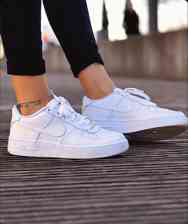

In [ ]:
path = 'data/nike/test_data/Matches/'
imgs = list(glob.glob(path + '*'))
idx = np.random.choice(len(imgs))
PIL.Image.open(imgs[idx])

# Models

In [ ]:
img_height, img_width = 128, 128
batch_size=32

## Nike

### Split data into training, testing, validation

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'data/nike/train_data',
  validation_split=0.1,
  subset='training',
  seed=42,
  label_mode = 'binary',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8166 files belonging to 2 classes.
Using 7350 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'data/nike/train_data',
  validation_split=0.1,
  subset='validation',
  seed=42,
  label_mode = 'binary',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8166 files belonging to 2 classes.
Using 816 files for validation.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    'data/nike/test_data',
    label_mode = 'binary',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 908 files belonging to 2 classes.


### Training the model

In [ ]:
model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False, input_shape=(224, 224, 3), pooling='avg', classes=2, weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False 
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
my_callbacks = [ModelCheckpoint("./saved_models/checkpoints/best_model", monitor='val_accuracy', verbose=0, save_best_only=True)]
history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=my_callbacks)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


230/230 [==============================] - 31s 118ms/step - loss: 0.6053 - accuracy: 0.6762 - val_loss: 0.5526 - val_accuracy: 0.7316
Epoch 2/100
230/230 [==============================] - 26s 114ms/step - loss: 0.5418 - accuracy: 0.7244 - val_loss: 0.5277 - val_accuracy: 0.7525
Epoch 3/100
230/230 [==============================] - 26s 113ms/step - loss: 0.5043 - accuracy: 0.7454 - val_loss: 0.5521 - val_accuracy: 0.7377
Epoch 4/100
230/230 [==============================] - 26s 113ms/step - loss: 0.4755 - accuracy: 0.7622 - val_loss: 0.5262 - val_accuracy: 0.7525
Epoch 5/100
230/230 [==============================] - 26s 113ms/step - loss: 0.4383 - accuracy: 0.7898 - val_loss: 0.5193 - val_accuracy: 0.7659
Epoch 6/100
230/230 [==============================] - 26s 113ms/step - loss: 0.4112 - accuracy: 0.8080 - val_loss: 0.5213 - val_accuracy: 0.7390
Epoch 7/100
230/230 [==============================] - 26s 113ms/step - loss: 0.3720 - accuracy: 0.8265 - val_loss: 0.5447 - val_accurac

### Evaluating the model

In [ ]:
model = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
model.evaluate(test_ds)

29/29 [==============================] - 4s 120ms/step - loss: 1.2479 - accuracy: 0.7874


[1.2478618621826172, 0.7874449491500854]

## Ed sheeran

### Split data into training, testing, validation

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'data/edsheeran/train_data',
  validation_split=0.1,
  subset='training',
  seed=42,
  label_mode = 'binary',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6814 files belonging to 2 classes.
Using 6133 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'data/edsheeran/train_data',
  validation_split=0.1,
  subset='validation',
  seed=42,
  label_mode = 'binary',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6814 files belonging to 2 classes.
Using 681 files for validation.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    'data/edsheeran/test_data',
    label_mode = 'binary',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 758 files belonging to 2 classes.


### Training the model

In [ ]:
model2 = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False, input_shape=(224, 224, 3), pooling='avg', classes=2, weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False 
model2.add(pretrained_model)
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
my_callbacks = [ModelCheckpoint("./saved_models/checkpoints/best_model", monitor='val_accuracy', verbose=0, save_best_only=True)]
history = model2.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=my_callbacks)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


192/192 [==============================] - 27s 125ms/step - loss: 0.2925 - accuracy: 0.8694 - val_loss: 0.3070 - val_accuracy: 0.8513
Epoch 2/100
192/192 [==============================] - 22s 116ms/step - loss: 0.2280 - accuracy: 0.8955 - val_loss: 0.2949 - val_accuracy: 0.8690
Epoch 3/100
192/192 [==============================] - 22s 114ms/step - loss: 0.1898 - accuracy: 0.9141 - val_loss: 0.2738 - val_accuracy: 0.8848
Epoch 4/100
192/192 [==============================] - 22s 115ms/step - loss: 0.1646 - accuracy: 0.9284 - val_loss: 0.2846 - val_accuracy: 0.8484
Epoch 5/100
192/192 [==============================] - 23s 117ms/step - loss: 0.1422 - accuracy: 0.9384 - val_loss: 0.2746 - val_accuracy: 0.8836
Epoch 6/100
192/192 [==============================] - 22s 115ms/step - loss: 0.1275 - accuracy: 0.9437 - val_loss: 0.2654 - val_accuracy: 0.8807
Epoch 7/100
192/192 [==============================] - 23s 116ms/step - loss: 0.1216 - accuracy: 0.9439 - val_loss: 0.2711 - val_accurac

### Evaluating the model

In [32]:
model2 = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
model2.evaluate(test_ds)

25/25 [==============================] - 4s 282ms/step - loss: 0.2428 - accuracy: 0.8946


[0.2427983903884888, 0.8945561957359314]

## Gucci

### Split data into training, testing, validation

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'data/gucci/train_data',
  validation_split=0.1,
  subset='training',
  seed=42,
  label_mode = 'binary',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8495 files belonging to 2 classes.
Using 7646 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'data/gucci/train_data',
  validation_split=0.1,
  subset='validation',
  seed=42,
  label_mode = 'binary',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 8495 files belonging to 2 classes.
Using 849 files for validation.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    'data/gucci/test_data',
    label_mode = 'binary',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 944 files belonging to 2 classes.


### Training the model

In [ ]:
model3 = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False, input_shape=(224, 224, 3), pooling='avg', classes=2, weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False 
model3.add(pretrained_model)
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
model3.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
my_callbacks = [ModelCheckpoint("./saved_models/checkpoints/best_model", monitor='val_accuracy', verbose=0, save_best_only=True)]
history = model3.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=my_callbacks)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


239/239 [==============================] - 43s 118ms/step - loss: 0.5746 - accuracy: 0.7133 - val_loss: 0.5102 - val_accuracy: 0.7468
Epoch 2/100
239/239 [==============================] - 26s 110ms/step - loss: 0.5077 - accuracy: 0.7550 - val_loss: 0.4899 - val_accuracy: 0.7703
Epoch 3/100
239/239 [==============================] - 27s 112ms/step - loss: 0.4686 - accuracy: 0.7760 - val_loss: 0.4703 - val_accuracy: 0.7821
Epoch 4/100
239/239 [==============================] - 27s 114ms/step - loss: 0.4349 - accuracy: 0.7943 - val_loss: 0.4747 - val_accuracy: 0.7856
Epoch 5/100
239/239 [==============================] - 28s 117ms/step - loss: 0.3968 - accuracy: 0.8203 - val_loss: 0.4641 - val_accuracy: 0.7833
Epoch 6/100
239/239 [==============================] - 28s 117ms/step - loss: 0.3643 - accuracy: 0.8355 - val_loss: 0.4705 - val_accuracy: 0.8021
Epoch 7/100
239/239 [==============================] - 28s 118ms/step - loss: 0.3252 - accuracy: 0.8527 - val_loss: 0.4672 - val_accurac

### Evaluating the model

In [ ]:
model3 = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
model3.evaluate(test_ds)

30/30 [==============================] - 4s 125ms/step - loss: 1.0434 - accuracy: 0.7958


[1.0434106550216675, 0.7957627058029175]

## Cristiano Ronaldo

### Split data into training, testing, validation

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'data/cristianoronaldo/train_data',
  validation_split=0.1,
  subset='training',
  seed=42,
  label_mode = 'binary',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5697 files belonging to 2 classes.
Using 5128 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'data/cristianoronaldo/train_data',
  validation_split=0.1,
  subset='validation',
  seed=42,
  label_mode = 'binary',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5697 files belonging to 2 classes.
Using 569 files for validation.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    'data/cristianoronaldo/test_data',
    label_mode = 'binary',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 634 files belonging to 2 classes.


### Training the model

In [ ]:
model4 = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False, input_shape=(224, 224, 3), pooling='avg', classes=2, weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False 
model4.add(pretrained_model)
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.2))
model4.add(Dense(64, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))

In [ ]:
model4.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
my_callbacks = [ModelCheckpoint("./saved_models/checkpoints/best_model", monitor='val_accuracy', verbose=0, save_best_only=True)]
history = model4.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=my_callbacks)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


161/161 [==============================] - 25s 133ms/step - loss: 0.4808 - accuracy: 0.7816 - val_loss: 0.4180 - val_accuracy: 0.8067
Epoch 2/100
161/161 [==============================] - 20s 120ms/step - loss: 0.4002 - accuracy: 0.8155 - val_loss: 0.3481 - val_accuracy: 0.8594
Epoch 3/100
161/161 [==============================] - 19s 117ms/step - loss: 0.3499 - accuracy: 0.8444 - val_loss: 0.3548 - val_accuracy: 0.8260
Epoch 4/100
161/161 [==============================] - 19s 116ms/step - loss: 0.3212 - accuracy: 0.8578 - val_loss: 0.3482 - val_accuracy: 0.8471
Epoch 5/100
161/161 [==============================] - 19s 118ms/step - loss: 0.2933 - accuracy: 0.8711 - val_loss: 0.3366 - val_accuracy: 0.8366
Epoch 6/100
161/161 [==============================] - 19s 118ms/step - loss: 0.2728 - accuracy: 0.8809 - val_loss: 0.3572 - val_accuracy: 0.8295
Epoch 7/100
161/161 [==============================] - 19s 117ms/step - loss: 0.2338 - accuracy: 0.9011 - val_loss: 0.3384 - val_accurac

### Evaluating the model

In [ ]:
model4 = tf.keras.models.load_model("./saved_models/checkpoints/best_model")
model4.evaluate(test_ds)

20/20 [==============================] - 3s 139ms/step - loss: 1.3388 - accuracy: 0.8155


[1.338785171508789, 0.8154574036598206]